# Moving on To Clustering/Classification

## First Step: Get Clustering Working Using Pretrained MobileNet

In [4]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms.functional as TF
from torchviz import make_dot
from torchsummary import summary
import numpy as np
from preprocess import pre_process, Box
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
pre_process("data/images/", "data/boxes")

100%|██████████| 327/327 [03:46<00:00,  1.44it/s]


In [2]:
box_ds = datasets.ImageFolder(
    root="data/boxes",
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
)
color_idx = [i for i in range(len(box_ds)) if box_ds.imgs[i][1] == box_ds.class_to_idx['color']]
bw_idx = [i for i in range(len(box_ds)) if box_ds.imgs[i][1] == box_ds.class_to_idx['bw']]

color_ds = Subset(box_ds, color_idx)
bw_ds = Subset(box_ds, bw_idx)

In [3]:
batch_size = 8
color_loader = DataLoader(color_ds, batch_size=batch_size, shuffle=False)

In [4]:
# Force ourselves to use CPU to support users without crazy GPUs
device = torch.device('cpu')
mobilenet_pretrained = models.mobilenet_v2(pretrained=True).to(device) 

/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
outputs_list = []
pbar = tqdm(total=len(color_loader))
for images, labels in color_loader:
    outputs = mobilenet_pretrained.features(images)
    outputs_list.append(outputs.detach().numpy())
    pbar.update(1)
outputs_array = np.concatenate(outputs_list)

100%|██████████| 231/231 [01:37<00:00,  2.50it/s]

In [6]:
num_samples, num_features = outputs_array.shape[0], np.prod(outputs_array.shape[1:])
outputs_array_reshaped = outputs_array.reshape(num_samples, num_features)

In [7]:
pca = PCA(n_components=2)  # Set the number of components as desired
pca_result = pca.fit_transform(outputs_array_reshaped)

In [8]:
pca_components = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

# Print the PCA results
print("PCA Components:")
print(pca_components)
print("Explained Variance Ratios:")
print(explained_variance_ratios)

PCA Components:
[[0.00395097 0.00515342 0.006051   ... 0.00729394 0.00657056 0.00507954]
 [0.00122214 0.00050215 0.00093674 ... 0.00389807 0.0043305  0.00324935]]
Explained Variance Ratios:
[0.04262622 0.01757285]


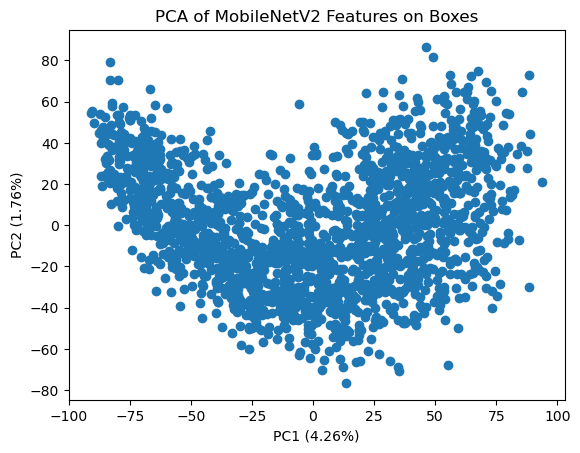

In [9]:
plt.scatter(pca_result[:, 0], pca_result[:, 1])
# Label axes with variance ratios
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("PCA of MobileNetV2 Features on Boxes")
plt.show()
    

## Reflections on First Attempt

Clustering on top of the pre-trained mobile-net is certainly doing _something_, but I don't think it's going to be able to separate well enough to give us anything _that_ useful. We could always try and fallback and perhaps just ask the user for input on a _lot_ of boxes, but this is time-consuming and bad UI. Let's first try to make this clustering better

### Ideas to Improve the Clustering

- Normalzing the output of the featuremap may help improve clustering.

- A lot of information is held in the shape of the box. Especially after our merging strategies, chat boxes and player info boxes tend to have relatively consistent (and different) shapes. If we attach this information to our data and then cluster, we might be able to get better results.
  - This is also a good opportunity to clean up how I was doing filname stuff earlier

In [14]:
class BoxDataset(Dataset):
    def __init__(self, inp_dir):
        self.inp_dir = inp_dir
        self.img_paths = []
        for root, dirs, files in os.walk(inp_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.img_paths.append(os.path.join(root, file))
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        raw_img = Image.open(img_path)
        img = self.transform(raw_img)
        return {
            "img": img,
            "width": raw_img.width,
            "height": raw_img.height,
            "timestamp": img_path.split("/")[-1].split("_")[0]
        }

In [16]:
color_ds = BoxDataset("data/boxes/color")

batch_size = 1
color_loader = DataLoader(color_ds, batch_size=batch_size, shuffle=False)

In [17]:
outputs_list = []
pbar = tqdm(total=len(color_loader))

num = 0
max_num = float("inf")
for item in color_loader:
    outputs = mobilenet_pretrained.features(item["img"])
    # Perform max pooling on the outputs
    outputs = torch.max(outputs, dim=3)[0]
    outputs = torch.max(outputs, dim=2)[0]
    # Attach height and width information
    outputs = torch.cat((outputs, torch.tensor([[item["width"] / 25, item["height"] / 25]])), dim=1)
    outputs_list.append(outputs.detach().numpy())
    pbar.update(1)
    num += 1
    if num >= max_num:
        break
outputs_array = np.concatenate(outputs_list)
# Apply standard scaling to outputs on a per-column basis
# outputs_array = (outputs_array - outputs_array.mean(axis=0)) / outputs_array.std(axis=0)

  0%|          | 0/231 [00:18<?, ?it/s]


PCA Components:
[[ 1.8656555e-03 -9.4587880e-04  1.9263563e-03 ...  6.4490228e-03
   8.9372838e-01  4.3468115e-01]
 [ 3.8237318e-03 -6.2393746e-04 -1.0465130e-03 ...  7.2216014e-03
  -4.3600619e-01  8.8813186e-01]]
Explained Variance Ratios:
[0.09473373 0.02912091]


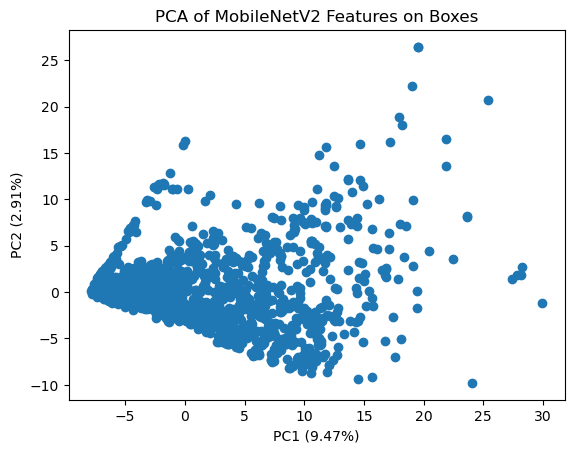

In [18]:
num_samples, num_features = outputs_array.shape[0], np.prod(outputs_array.shape[1:])
outputs_array_reshaped = outputs_array.reshape(num_samples, num_features)
pca = PCA(n_components=2)  # Set the number of components as desired
pca_result = pca.fit_transform(outputs_array_reshaped)
pca_components = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

# Print the PCA results
print("PCA Components:")
print(pca_components)
print("Explained Variance Ratios:")
print(explained_variance_ratios)

# Plot the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1])
# Label axes with variance ratios
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("PCA of MobileNetV2 Features on Boxes")
plt.show()
    

In [ ]:
def cluster(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(data)
    # silhouette_score = silhouette_score(data, kmeans.labels_)
    return kmeans, silhouette_score

num_clusters = 3
kmeans, silhouette_score = cluster(outputs_array_reshaped, num_clusters)

## Using Shape Only

I wasn't completely satisfied with the analysis above which used both feature information and shape information. Before moving on to developing a working version of the processing and aggregation, I wanted to take a stab at a slightly simpler problem which performed grouping strictly by box meta data, including width, height, but now also top and left coordinates.


I realized that part of the problem was likely that I was starting with a compilation video, which included a variety of streamers with substantialy different layouts

In [26]:
class ShapeDataset(Dataset):
    def __init__(self, inp_dir):
        self.inp_dir = inp_dir
        self.txt_paths = []
        for root, dirs, files in os.walk(inp_dir):
            for file in files:
                if file.endswith(".txt"):
                    self.txt_paths.append(os.path.join(root, file))
    
    def __len__(self):
        return len(self.txt_paths)
    
    def __getitem__(self, idx):
        txt_path = self.txt_paths[idx]
        with open(txt_path, "r") as f:
            box = Box.from_str(f.read().split("\n")[0])
        return {
            "left": box.left,
            "top": box.top,
            "width": box.width,
            "height": box.height,
            "timestamp": txt_path.split("/")[-1].split("_")[0]
        }

In [27]:
shape_ds = ShapeDataset("data/boxes/meta")
batch_size = 128
shape_loader = DataLoader(shape_ds, batch_size=batch_size, shuffle=False)

In [44]:
num = 0
max_num = float("inf")

outputs_list = []
pbar = tqdm(total=len(shape_loader))

for item in shape_loader:
    data = np.column_stack((item["left"], item["top"], item["width"], item["height"]))
    outputs_list.append(data)
    pbar.update(1)
    num += 1
    if num >= max_num:
        break

outputs_array = np.concatenate(outputs_list)


100%|██████████| 15/15 [00:01<00:00,  9.46it/s]

(1846, 4)


PCA Components:
[[ 0.97206559 -0.23069756 -0.04285475  0.00553206]
 [-0.23197837 -0.97224493 -0.02605904  0.01570869]]
Explained Variance Ratios:
[0.69509042 0.23409679]


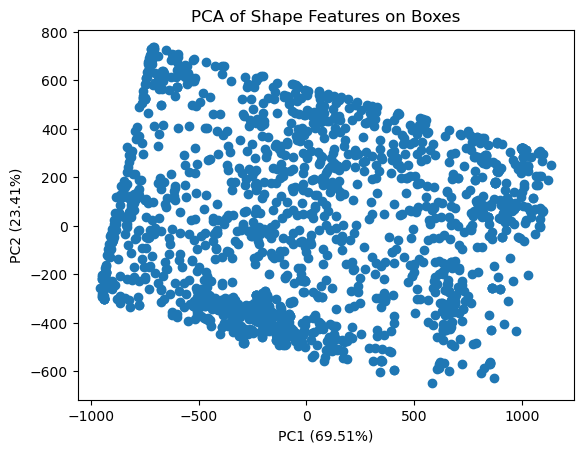

In [46]:
num_samples, num_features = outputs_array.shape[0], np.prod(outputs_array.shape[1:])
outputs_array_reshaped = outputs_array.reshape(num_samples, num_features)
pca = PCA(n_components=2)  # Set the number of components as desired
pca_result = pca.fit_transform(outputs_array_reshaped)
pca_components = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

# Print the PCA results
print("PCA Components:")
print(pca_components)
print("Explained Variance Ratios:")
print(explained_variance_ratios)

# Plot the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1])
# Label axes with variance ratios
plt.xlabel(f"PC1 ({explained_variance_ratios[0] * 100:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance_ratios[1] * 100:.2f}%)")
plt.title("PCA of Shape Features on Boxes")
plt.show()
    

In [ ]:
# Force ourselves to use CPU to support users without crazy GPUs
device = torch.device('cpu')

In [ ]:
image = Image.open("data/league/f_10000.jpg")   #Line 8
image = image.resize((224,224))       #Line 9
x = TF.to_tensor(image)             #Line 10
x.unsqueeze_(0)                     #Line 11
x = x.to(device)                      #Line 12
print(x.shape)

In [ ]:
mobilenet_pretrained = models.mobilenet_v2(pretrained=True).to(device) 

In [ ]:
summary(mobilenet_pretrained, (3, 224, 224))

In [ ]:
pred = mobilenet_pretrained.features(x)
print(pred.shape)
print(pred)

In [ ]:
mobilenet_pretrained = models.mobilenet_v2(pretrained=True).to(device)
def to_mobilenet_features(img):
    return mobilenet_pretrained.features(x)

image = cv2.imread("data/league/f_10000.jpg")
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
to_mobilenet_features(rgb)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
def load_dataset(path: str):
    return datasets.ImageFolder(
        root=path,
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
    )

ds = load_dataset("data/test_cluster/train")
print(ds)
print(ds.classes)
print(ds[1][0].shape)
print(ds[1][0].unsqueeze_(0).shape)

In [ ]:
mobilenet_pretrained.features(ds[1][0].unsqueeze_(0))

In [ ]:
batch_size = 8
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=False)

In [ ]:
outputs_list = []
for images, labels in dataloader:
    outputs = mobilenet_pretrained.features(images)
    outputs_list.append(outputs.detach().numpy())
outputs_array = np.concatenate(outputs_list)

In [ ]:
num_samples, num_features = outputs_array.shape[0], np.prod(outputs_array.shape[1:])
outputs_array_reshaped = outputs_array.reshape(num_samples, num_features)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)  # Set the number of components as desired
pca_result = pca.fit_transform(outputs_array_reshaped)

In [ ]:
pca_components = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

# Print the PCA results
print("PCA Components:")
print(pca_components)
print("Explained Variance Ratios:")
print(explained_variance_ratios)

In [ ]:
# Plot the PCA results
import matplotlib.pyplot as plt

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ds.targets, cmap='plasma')